<a href="https://colab.research.google.com/github/Pjh940114/ch_project_3/blob/master/220709_%5BModel2%5D_(SP_based_Dict_LSTM)_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 설치
!set -x \
&& pip install konlpy \
&& curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh | bash -x

!pip install pandas-datareader

+ pip install konlpy
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 4.6 MB/s 
     |████████████████████████████████| 453 kB 50.7 MB/s 
+ curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh
+ bash -x
+ mecab_dicdir=/usr/local/lib/mecab/dic/mecab-ko-dic
+ set -e
++ uname
+ os=Linux
+ [[ ! Linux == \L\i\n\u\x ]]
+ hash sudo
+ sudo=sudo
+ python=python3
+ hash pyenv
+ at_user_site=
++ check_python_site_location_is_writable
++ python3 -
+ [[ 1 == \0 ]]
+ hash automake
+ echo 'Installing automake (A dependency for mecab-ko)'
Installing automake (A dependency for mecab-ko)
+ install_automake
+ '[' Linux == Linux ']'
++ grep -Ei 'debian|buntu|mint' /etc/lsb-release /etc/os-release
+ '[' '/etc/lsb-release:DISTRIB_ID=Ubuntu
/etc/lsb-release:DISTRIB_DESCRIPTION="Ubuntu 18.04.5 LTS"
/etc/os-release:NAME="Ubuntu"
/etc/os-release:ID=ubuntu
/etc/os-release:ID_LIKE=debian
/e

In [ ]:
# 주피터
# import os

# os.chdir('G:/내 드라이브/projects/NLP-StockMarket/model_fin/')

In [ ]:
# 코랩
from google.colab import drive
drive.mount("/content/drive")

import os
path = '/content/drive/MyDrive/krx_nlp' # 본인 구글 드라이브 계정마다 살짝씩 다를 수도 있음
os.chdir(path)

Mounted at /content/drive


## 필요모듈 import

In [ ]:
!pip install konlpy   # 코랩에서만 실행

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
import scipy as sp
import pandas as pd
import numpy as np
import re

from konlpy.tag import Kkma    
from konlpy.tag import Hannanum    
from konlpy.tag import Okt        
from konlpy.tag import *
import nltk
import pickle

# from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.tree import export_graphviz
from datetime import datetime, timedelta

import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [ ]:
kkma = Kkma()
hannanum = Hannanum()
okt = Okt()

## 자연어 데이터 import(날짜 가져오기 위해 먼저 가져옴)

In [ ]:
# LG화학, 삼성SDI, SK이노베이션, 고려아연, 포스코케미칼
stock_name = '삼성SDI'

In [ ]:
naver_news = pd.read_csv('./data/refined_naver_news.csv', index_col=0)
daum_news = pd.read_csv('./data/refined_daum_news.csv', index_col=0)
naver_talks = pd.read_csv(f'./data/refined_naver_talks_{stock_name}.csv', index_col=0)
daum_talks = pd.read_csv(f'./data/refined_daum_talks_{stock_name}.csv', index_col=0)
youtube = pd.read_csv(f'./data/refined_youtube_{stock_name}.csv', index_col=0)

In [ ]:
naver_talks['Date'] = pd.to_datetime(naver_talks['Date'])
daum_talks['Date'] = pd.to_datetime(daum_talks['Date'])

In [ ]:
news_df = pd.concat([naver_news, daum_news, naver_talks, daum_talks ,youtube])
news_df['Date'] = pd.to_datetime(news_df['Date'].astype(str))     # str(변수) 는 자체 내장함수, 변수 하나씩밖에 적용 안됨.
news_df.sort_values('Date', ignore_index=True, inplace=True)

In [ ]:
news_df[news_df['Date']== '2021-01-04'].head(2)

,Date,Title
665,2021-01-04,화신 52주 신고가 경신 단기 중기 이평선 정배열로 상승세
666,2021-01-04,옵트론텍 52주 신고가 경신 전일 외국인 대량 순매도


In [ ]:
news_df[news_df['Date']== '2021-01-04'].index[0]

665

In [ ]:
news_df = news_df[news_df[news_df['Date']== '2021-01-04'].index[0]:]
news_df.head(3)

,Date,Title
665,2021-01-04,화신 52주 신고가 경신 단기 중기 이평선 정배열로 상승세
666,2021-01-04,옵트론텍 52주 신고가 경신 전일 외국인 대량 순매도
667,2021-01-04,코스피 마감 70 98포인트 2 47 오른 2 944 45 마감


## 주가 데이터

### KRX에서 받은 csv로 가져오기

In [ ]:
stock_df = pd.read_csv(f'./data/{stock_name}_주가_데이터.csv', usecols = ['일자','등락률'])
stock_df['일자'] = pd.to_datetime(stock_df['일자'])
stock_df.head()

,일자,등락률
0,2021-01-04,6.85
1,2021-01-05,2.24
2,2021-01-06,-0.87
3,2021-01-07,2.65
4,2021-01-08,5.87


In [ ]:
start = str(stock_df.iloc[0, 0])
end = str(stock_df.iloc[-1, 0])
print(start)
print(end)

2021-01-04 00:00:00
2022-06-30 00:00:00


In [ ]:
# 2진분류
stock_df['updown'] = 0
for i in tqdm(range(len(stock_df))):
    if stock_df['등락률'][i] > 0:
        stock_df['updown'][i] = 1
    else:
        stock_df['updown'][i] = 0
stock_df.head()

100%|██████████| 369/369 [00:00<00:00, 1330.22it/s]


,일자,등락률,updown
0,2021-01-04,6.85,1
1,2021-01-05,2.24,1
2,2021-01-06,-0.87,0
3,2021-01-07,2.65,1
4,2021-01-08,5.87,1


In [ ]:
## 뉴스일자 조정(예측대상(주가)의 일자와 맞추기 위해)
news_df['일자'] = news_df['Date'] + timedelta(days=1)

## 합치기

In [ ]:
df = news_df.merge(stock_df)
df.columns = [df.columns[0], df.columns[1], '주가의 날짜', '등락률(y)', 'updown']
df.drop_duplicates('Title', inplace = True, ignore_index = True)  # 기사제목 중복 제거
print(len(df))
df.head()

440418


,Date,Title,주가의 날짜,등락률(y),updown
0,2021-01-04,화신 52주 신고가 경신 단기 중기 이평선 정배열로 상승세,2021-01-05,2.24,1
1,2021-01-04,옵트론텍 52주 신고가 경신 전일 외국인 대량 순매도,2021-01-05,2.24,1
2,2021-01-04,코스피 마감 70 98포인트 2 47 오른 2 944 45 마감,2021-01-05,2.24,1
3,2021-01-04,표 KRX 금 시세 1월 4일,2021-01-05,2.24,1
4,2021-01-04,에스씨엠생명과학 52주 신고가 경신 단기 중기 이평선 정배열로 상승세,2021-01-05,2.24,1


## Title 에서 종목명 제거

### 종목명 불러오기

In [ ]:
stopstocks = pd.read_csv("./data/종목명.csv", encoding = 'cp949')
stopstocks = stopstocks['한글 종목약명'].tolist()
stopstocks.extend(['코스피', '코스닥', '코넥스', '삼성', '하이닉스', '엔솔', '다우존스', '다우', '다우지수', '빅히트', '코스콤'])
# stopstocks

In [ ]:
print(df['Title'][0])

for i in tqdm(range(len(df['Title']))):
  for stopstock in stopstocks:
    if stopstock in df['Title'][i]:
      df['Title'][i] = df['Title'][i].replace(stopstock,'')

df['Title'][0]

 화신  52주 신고가 경신  단기 중기 이평선 정배열로 상승세


100%|██████████| 440418/440418 [2:38:36<00:00, 46.28it/s]


'   52주 신고가 경신  단기 중기 이평선 정배열로 상승세'

In [ ]:
# csv 저장
df.to_csv("df(nostockname).csv", mode='w', encoding = 'utf-8-sig')

## 감성분석 모델 적용

### 감성사전 만들기

In [ ]:
n_ = []
title_rename = []
for i in tqdm(range(len(df))):
    title_rename.append(re.sub("[\(\[].*?[\)\]]", "",df.iloc[i]['Title']))
    n_.append(' '.join(okt.nouns(df.iloc[i]['Title'])))
df['nouns'] = n_
df['Title']=title_rename
df = df[df['nouns']!='']

100%|██████████| 440418/440418 [15:45<00:00, 465.90it/s]


In [ ]:
vocab = {}
cnt = 0
for i in tqdm(df['nouns']):
    i = i.split(' ')
    for j in range(len(i)):
        if i[j] in vocab or len(i[j]) <= 1:
            cnt = cnt+1
            pass
        else:
            vocab[i[j]] = 0
print(len(vocab))
print(vocab)

100%|██████████| 438313/438313 [00:01<00:00, 279653.02it/s]

35060
{'신고': 0, '경신': 0, '단기': 0, '중기': 0, '이평': 0, '배열': 0, '상승세': 0, '전일': 0, '외국인': 0, '대량': 0, '매도': 0, '마감': 0, '포인트': 0, '오른': 0, '시세': 0, '신년사': 0, '박정림': 0, '김성현': 0, '대표': 0, '디지털': 0, '경영': 0, '체계': 0, '강화': 0, '스톡': 0, '톡스': 0, '산업': 0, '변환기': 0, '구조': 0, '상승': 0, '올해': 0, '저하': 0, '전망': 0, '규모': 0, '진천': 0, '공장': 0, '시설': 0, '증축': 0, '계약': 0, '새해': 0, '거래': 0, '사상': 0, '최고': 0, '행진': 0, '전환사채': 0, '전환': 0, '가액': 0, '조정': 0, '영채': 0, '고객': 0, '신뢰': 0, '중요': 0, '개인': 0, '매수': 0, '시장': 0, '증가': 0, '투자자': 0, '매매': 0, '동향': 0, '종료': 0, '증권': 0, '간다': 0, '달러': 0, '환율': 0, '기관': 0, '속보': 0, '돌파': 0, '최석': 0, '투자': 0, '책임': 0, '최근': 0, '주가': 0, '다시': 0, '한번': 0, '각각': 0, '연속': 0, '증시': 0, '대림': 0, '김상우': 0, '각자': 0, '대표이사': 0, '단독': 0, '프로그램': 0, '우위': 0, '포토': 0, '첫날': 0, '동학': 0, '개미': 0, '신축년': 0, '기염': 0, '비엠': 0, '클럽': 0, '신규': 0, '가입': 0, '특별': 0, '관계자': 0, '변동': 0, '의성군': 0, '청년': 0, '농업인': 0, '스마트': 0, '조성': 0, '단지': 0, '운영': 0, '업체': 0, '선정': 0, '변수': 0, '우상': 0, '그래프': 0,

In [ ]:
# df

In [ ]:
up = df['updown'].value_counts()[1]
down = df['updown'].value_counts()[0]
up_ratio = up/(up+down)
down_ratio = down/(up+down)

import collections
for i,w in tqdm(enumerate(df['nouns'])):
    w = w.split(' ')
    if (df.iloc[i]['updown']==1):
        for j in range(len(w)):
            noun = w[j]
            if len(noun)<=1:
                continue
            vocab[noun] = vocab[noun] + down_ratio
    else:
        for j in range(len(w)):
            noun = w[j]
            if len(noun)<=1:
                continue
            vocab[noun] = vocab[noun] - up_ratio

438313it [01:18, 5563.17it/s]


In [ ]:
# vocab_score 저장!!!
import csv
with open('[Model2]vocab_score_nostockname.csv', 'w', newline = '', encoding = 'utf-8-sig') as f:  
    writer = csv.writer(f)
    for k, v in vocab.items():
       writer.writerow([k, v])

In [ ]:
sent_dictionary = vocab
total = []
for i,w  in tqdm(enumerate(df['nouns'])):
    sent_score = 0
    w= w.split(' ')
    for j in w:
        if(len(j)<=1):
            continue
        elif(j not in sent_dictionary):
            continue
        else:
            sent_score = sent_score + sent_dictionary[j]
    total.append(sent_score/len(w))
df['sent_score'] = total

438313it [00:02, 187639.89it/s]


In [ ]:
# df = df.drop(columns = ['sent_label'])
df

,Date,Title,주가의 날짜,등락률(y),updown,nouns,sent_score
0,2021-01-04,52주 신고가 경신 단기 중기 이평선 정배열로 상승세,2021-01-05,2.24,1,주 신고 경신 단기 중기 이평 선 정 배열 상승세,82.477768
1,2021-01-04,52주 신고가 경신 전일 외국인 대량 순매도,2021-01-05,2.24,1,주 신고 경신 전일 외국인 대량 매도,77.382073
2,2021-01-04,마감 70 98포인트 2 47 오른 2 944 45 마감,2021-01-05,2.24,1,마감 포인트 오른 마감,106.381457
3,2021-01-04,표 KRX 금 시세 1월 4일,2021-01-05,2.24,1,표 금 시세,10.216013
4,2021-01-04,52주 신고가 경신 단기 중기 이평선 정배열로 상승세,2021-01-05,2.24,1,주 신고 경신 단기 중기 이평 선 정 배열 상승세,82.477768
...,...,...,...,...,...,...,...
440413,2022-06-29,봉쇄 풀고 친환경 정책 강화 中 ETF 수익률 상위 휩쓸어,2022-06-30,-6.67,0,봉쇄 풀 친환경 정책 강화 수익률 상위,-9.265061
440414,2022-06-29,디지털플랫폼정부위원회 출범 위세 성장 속도 빨라질 것,2022-06-30,-6.67,0,디지털 플랫폼 정부 위원회 출범 위세 성장 속도 것,-11.321955
440415,2022-06-29,IBK證 사랑의열매에 중소기업 물품 후원,2022-06-30,-6.67,0,사랑 열매 중소기업 물품 후원,-6.772329
440416,2022-06-29,불 붙은 원숭이두창 진단 경쟁 국내 최대 도 개발 중 Why 바이오,2022-06-30,-6.67,0,불 원숭이 두창 진단 경쟁 국내 최대 도 개발 중 바이오,-19.854664


In [ ]:
# ## 평균값 이상인 경우 1, 아닌 경우 0
# df['sent_label'] = 0
# df

In [ ]:
sum = 0
for i in tqdm(range(len(vocab))):
    sum = sum + list(vocab.values())[i]
sent_mean = sum/len(vocab)

a_ = []
for i in tqdm(range(len(df))):
  if(df.iloc[i]['sent_score']>sent_mean):
      a_.append(1)
  else:
      a_.append(0)

df['sent_label'] = a_
print("sent_mean :", sent_mean)
df.head(5)

100%|██████████| 438313/438313 [01:12<00:00, 6048.64it/s]


sent_mean : -0.12946018842923965


,Date,Title,주가의 날짜,등락률(y),updown,nouns,sent_score,sent_label
0,2021-01-04,52주 신고가 경신 단기 중기 이평선 정배열로 상승세,2021-01-05,2.24,1,주 신고 경신 단기 중기 이평 선 정 배열 상승세,82.477768,1
1,2021-01-04,52주 신고가 경신 전일 외국인 대량 순매도,2021-01-05,2.24,1,주 신고 경신 전일 외국인 대량 매도,77.382073,1
2,2021-01-04,마감 70 98포인트 2 47 오른 2 944 45 마감,2021-01-05,2.24,1,마감 포인트 오른 마감,106.381457,1
3,2021-01-04,표 KRX 금 시세 1월 4일,2021-01-05,2.24,1,표 금 시세,10.216013,1
4,2021-01-04,52주 신고가 경신 단기 중기 이평선 정배열로 상승세,2021-01-05,2.24,1,주 신고 경신 단기 중기 이평 선 정 배열 상승세,82.477768,1


In [ ]:
df['sent_label'].value_counts()

1    260546
0    177767
Name: sent_label, dtype: int64

In [ ]:
# Mecab 은 colab!

In [ ]:
df['tokenized'] = 0

In [ ]:
from konlpy.tag import Mecab
# train_data, validation_data = train_test_split(df_train, test_size = 0.2, random_state = 42)

df.dropna(how='any',inplace= True)
# validation_data.dropna(how='any', inplace=True)
df['tokenized'] = df['Title'].apply(okt.morphs)   # 또는 자유롭게 라이브러리 사용
# mecab = Mecab() 
# validation_data['tokenized'] = validation_data['제목'].apply(mecab.morphs)
X_train = df['tokenized'].values
Y_train = df['sent_label'].values
# X_vali= validation_data['tokenized'].values
# Y_vali = validation_data['sent_label'].values

In [ ]:
# from konlpy.tag import Mecab
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# 빈도 수가 낮은 단어 제거
threshold = 3 # 3개 미만이면 제거

words_cnt = len(tokenizer.word_index)
rare_cnt = 0
words_freq = 0
rare_freq = 0

for key, value in tqdm(tokenizer.word_counts.items()):
    words_freq = words_freq + value

    if value < threshold:
        rare_cnt += 1
        rare_freq = rare_freq + value

print("전체 단어 수 :", words_cnt)
print("빈도가 {} 이하인 희귀 단어 수 : {}".format(threshold-1, rare_cnt))
print("희귀 단어 비율 : {}".format((rare_cnt/words_cnt) * 100))
print("희귀 단어 등장 빈도 비율 : {}".format((rare_freq / words_freq) * 100))

100%|██████████| 85019/85019 [00:00<00:00, 1004601.99it/s]

전체 단어 수 : 85019
빈도가 2 이하인 희귀 단어 수 : 45832
희귀 단어 비율 : 53.907949987649815
희귀 단어 등장 빈도 비율 : 1.3170435125542264


In [ ]:
vocab_size = words_cnt - rare_cnt + 2
print(vocab_size)

39189


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
# X_vali = tokenizer.texts_to_sequences(X_vali)

In [ ]:
print('리뷰 최대 길이 :', max(len(i) for i in X_train))
# print('리뷰 평균 길이 :', sum(map(len, X_train))/ len(X_train))

리뷰 최대 길이 : 42


In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in tqdm(nested_list):
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 25
below_threshold_len(max_len, X_train)

# 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
# X_vali = pad_sequences(X_vali, maxlen = max_len)

100%|██████████| 438313/438313 [00:00<00:00, 2262200.52it/s]


전체 샘플 중 길이가 25 이하인 샘플의 비율: 99.78280361294325


## 모델링-LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU, LSTM, Bidirectional
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

# model = Sequential()
# model.add(Embedding(vocab_size, 30))
# model.add(LSTM(128)) # overfitting -> dropout
# model.add(Dense(1, activation = 'sigmoid'))

# model.compile(optimizer = 'rmsprop',
#               loss = 'binary_crossentropy',
#               metrics = ['acc'])
model.summary()

Epoch 1/15
1370/1370 [==============================] - ETA: 0s - loss: 0.1404 - acc: 0.9389
Epoch 1: val_acc improved from -inf to 0.95921, saving model to best_model.h5
1370/1370 [==============================] - 373s 266ms/step - loss: 0.1404 - acc: 0.9389 - val_loss: 0.0953 - val_acc: 0.9592
Epoch 2/15
1370/1370 [==============================] - ETA: 0s - loss: 0.0704 - acc: 0.9714
Epoch 2: val_acc improved from 0.95921 to 0.96489, saving model to best_model.h5
1370/1370 [==============================] - 360s 263ms/step - loss: 0.0704 - acc: 0.9714 - val_loss: 0.0819 - val_acc: 0.9649
Epoch 3/15
1370/1370 [==============================] - ETA: 0s - loss: 0.0592 - acc: 0.9768
Epoch 3: val_acc improved from 0.96489 to 0.96733, saving model to best_model.h5
1370/1370 [==============================] - 358s 261ms/step - loss: 0.0592 - acc: 0.9768 - val_loss: 0.0805 - val_acc: 0.9673
Epoch 4/15
1370/1370 [==============================] - ETA: 0s - loss: 0.0528 - acc: 0.9795
Epoch 4

In [ ]:
# 저장된 모델 불러오기, 평가
loaded_model = load_model('best_model.h5')
loaded_model.evaluate(X_train, Y_train)

13698/13698 [==============================] - 169s 12ms/step - loss: 0.0525 - acc: 0.9799


[0.052498191595077515, 0.9798659682273865]

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


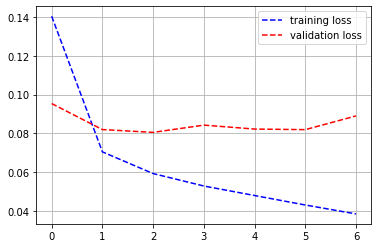

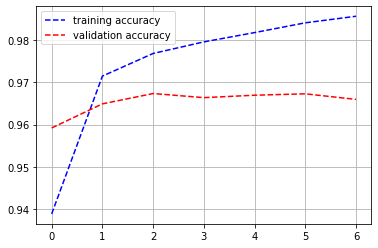

In [ ]:
# 시각화

hist_dict = history.history
loss = hist_dict['loss']
val_loss = hist_dict['val_loss']
acc = hist_dict['acc']
val_acc = hist_dict['val_acc']

plt.plot(loss, 'b--', label = 'training loss')
plt.plot(val_loss, 'r--', label = 'validation loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(acc, 'b--', label = 'training accuracy')
plt.plot(val_acc, 'r--', label = 'validation accuracy')
plt.legend()
plt.grid()

plt.show()

In [ ]:
# 임의 불용어
stopwords1 = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords2 = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
stopwords = list(set(stopwords1 + stopwords2))

def sentiment_predict(new_sentence):
  # # mecab
  # new_token = [word for word in mecab.morphs(new_sentence) if not word in stopwords]
  # okt
  new_token = [word for word in okt.morphs(new_sentence) if not word in stopwords]
  new_sequences = tokenizer.texts_to_sequences([new_token])
  new_pad = pad_sequences(new_sequences, maxlen = max_len)
  score = float(loaded_model.predict(new_pad))

  if score > 0.5:
      print("{} -> 긍정 ({:.2f}%)".format(new_sentence, score * 100))
  else:
      print("{} -> 부정 ({:.2f}%)".format(new_sentence, (1-score) * 100))

In [ ]:
sentiment_predict("[유럽개장] 장초반 상승세…英 1.03%↑")
sentiment_predict("[시황종합] 코스피, '침체우려'에 장중 연저점 경신…2300선 턱걸이 마감")

[유럽개장] 장초반 상승세…英 1.03%↑ -> 긍정 (99.98%)
[시황종합] 코스피, '침체우려'에 장중 연저점 경신…2300선 턱걸이 마감 -> 긍정 (100.00%)


## vocab 확인

In [ ]:
import pandas as pd 

df = pd.DataFrame([vocab])

In [ ]:
vocab_values = list(vocab.values())
vocab_values

vocab_values2 = []

for i in tqdm(range(len(vocab_values))): 
    vocab_values2.append(round(vocab_values[i],2))
  

100%|██████████| 35060/35060 [00:00<00:00, 182998.74it/s]


In [ ]:
print(max(vocab_values2))
print(min(vocab_values2))

639.12
-404.09


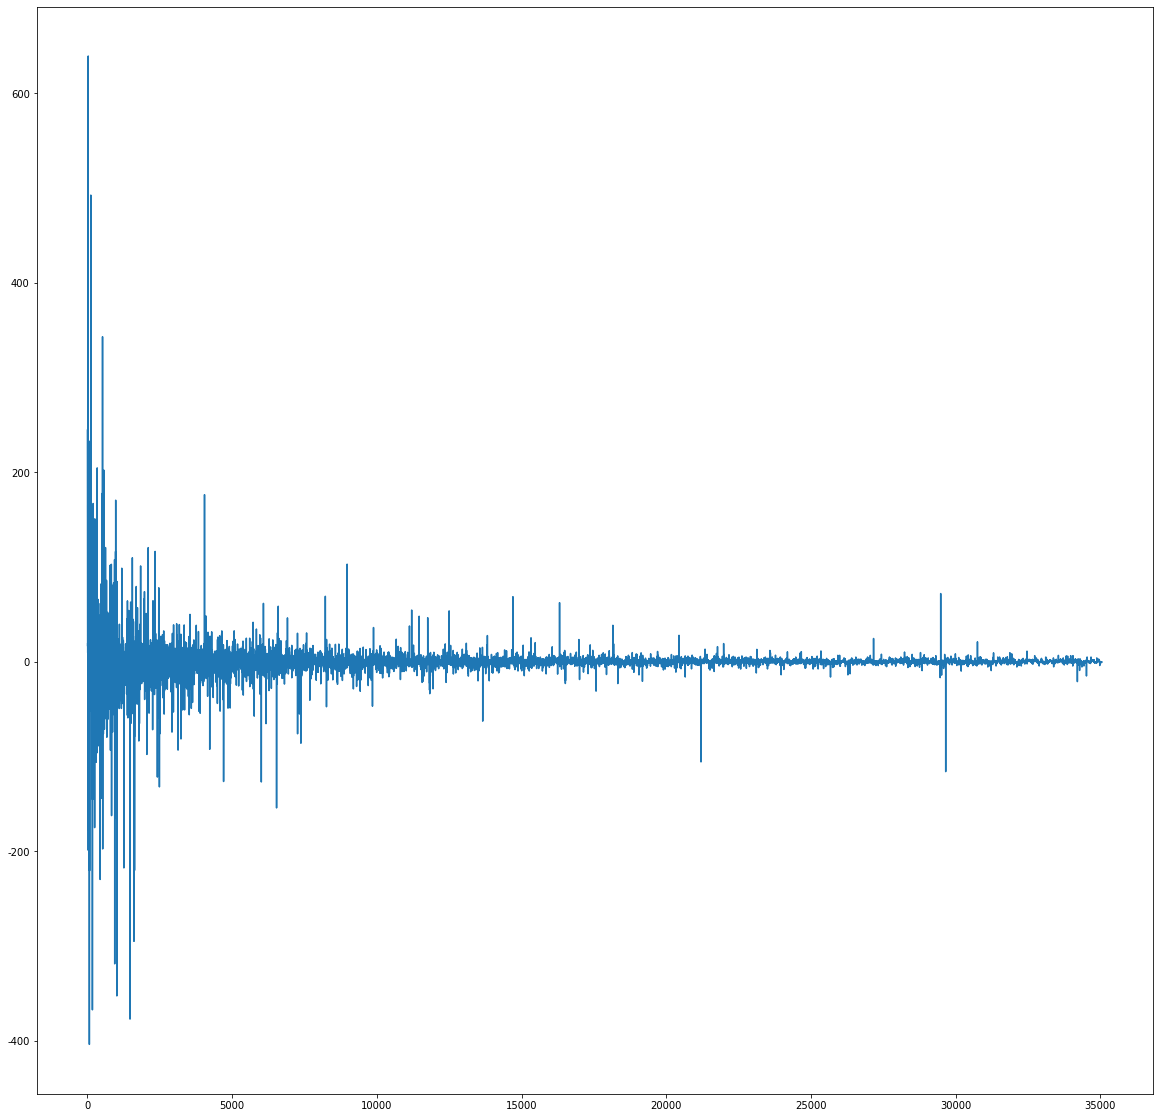

In [ ]:
fig = plt.figure(figsize = (20,20))
plt.plot(range(len(vocab_values2)), vocab_values2)